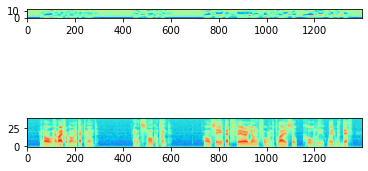

In [ ]:
# kaldi compliance feature extraction
import librosa
!pip install torchaudio
import torchaudio
import torch
import matplotlib.pyplot as plot

r"""Downloading LibriSpeech comes with its own train, validation and test sets available data (about 1000h of audio files)"""

Libri = torchaudio.datasets.LIBRISPEECH('.', download=False)

mfcc = torchaudio.compliance.kaldi.mfcc(Libri[0][0], sample_frequency=Libri[0][1], num_mel_bins=23, num_ceps=13, window_type='povey')
sample_frequency=Libri[0][1]

plot.subplot(211)
plot.imshow(mfcc.transpose(0,1), cmap='rainbow', origin='lowest', aspect=3)

fbank = torchaudio.compliance.kaldi.fbank(Libri[0][0], sample_frequency=Libri[0][1], num_mel_bins=40)
plot.subplot(212)
plot.imshow(fbank.transpose(0,1), cmap='rainbow', origin='lowest',aspect=3)

Torchaudio is built on PyTorch, these techniques can be used as building blocks for more advanced audio applications, such as speech recognition, while leveraging GPUs. Facebook paper wave2letter clamied that Both power spectrum
and raw features are performing slightly worse than MFCCs. We will compare multipe input feats in terms of ASR WER.

In [1]:
! git clone https://github.com/zcaceres/spec_augment.git
!pwd
%cd spec_augment/
!pip install fire
!python3 notebook2script.py SparseImageWarp.ipynb
print('done')

Cloning into 'spec_augment'...
remote: Enumerating objects: 109, done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 109
Receiving objects: 100% (109/109), 27.89 MiB | 36.24 MiB/s, done.
Resolving deltas: 100% (49/49), done.
/content
/content/spec_augment
     |████████████████████████████████| 81kB 3.4MB/s 
  Created wheel for fire: filename=fire-0.3.1-py2.py3-none-any.whl size=111005 sha256=0cd36749f3156c3ee42eddb3a437552e007fdd3186dc4830e31bd033ad99f7ef
  Stored in directory: /root/.cache/pip/wheels/c1/61/df/768b03527bf006b546dce284eb4249b185669e65afc5fbb2ac
Successfully built fire
Converted SparseImageWarp.ipynb to nb_SparseImageWarp.py
done


In [ ]:
from collections import namedtuple
import matplotlib.pyplot as plt
!pip install torchaudio
import torch
import torchaudio
from exp.nb_SparseImageWarp import sparse_image_warp
from IPython.display import Audio

wav = '../2.wav'
AudioData = namedtuple('AudioData', ['sig', 'sr'])
#audio = AudioData(*torchaudio.load(wav))
audio, sr = torchaudio.load_wav(wav)

r""" spectogram feature extraction"""
sample_rate = 16000
n_fft = 400.0
n_fft = 400.0
frame_length = n_fft / sample_rate *1000.0
frame_shift = frame_length / 2.0

params = {
    "channel": 0,
    "dither": 0.0,
    "window_type": "povey",
    "frame_length": frame_length,
    "frame_shift": frame_shift,
    "remove_dc_offset": False,
    "round_to_power_of_two": False,
    "sample_frequency": sample_rate,
}
spec = torchaudio.compliance.kaldi.spectrogram(audio,**params)

def tensor_to_img(spectrogram):
    plt.figure(figsize=(18,18)) 
    plt.imshow(spectrogram.transpose(0,1))
    plt.show();
    display(spectrogram.shape)
tensor_to_img(spec)
r""" move feats tensor from cpu to GPU vise versa """
device =('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
spec = spec.to(device).to('cpu')

In [2]:
!pip install torchaudio

from torchaudio import transforms
from collections import namedtuple
import matplotlib.pyplot as plt
import torch
import torchaudio
from exp.nb_SparseImageWarp import sparse_image_warp
from IPython.display import Audio


     |████████████████████████████████| 6.7MB 2.7MB/s 


torch.Size([1, 128, 1081])


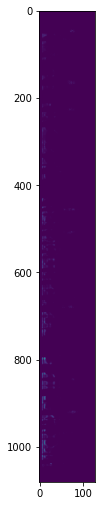

torch.Size([1, 1081, 128])

torch.Size([1, 1081, 128])


In [3]:
wav = '../2.wav'
AudioData = namedtuple('AudioData',['val','sr'])
audio = AudioData(*torchaudio.load(wav))
def tfm_spectro(ad:Audio, sr=16000, to_db_scale=False, n_fft=1024, hop=None, f_min=0.0, f_max=-80, pad=0, n_mels=128):
    melspectogram = transforms.MelSpectrogram(sr, n_mels=n_mels, n_fft=n_fft, f_min=f_min, f_max=f_max, pad=pad)(ad.val.reshape(1,-1))

    return melspectogram
spec=tfm_spectro(audio, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)
print(spec.shape)
spec = spec.permute(0,2,1) # permute wher num_mels is the 3'rd dim


def tensor_to_img(spectrogram):
    plt.figure(figsize=(1,14)) 
    plt.imshow(spectrogram[0])
    plt.show();
    display(spectrogram.shape)
tensor_to_img(spec)
print(spec.shape)

Spec Augmentation has 3 types of features augmentation. https://arxiv.org/pdf/1904.08779.pdf discribed Time Warp, Frequency warp and combined.

Time warping is applied via the function sparse image warp of tensorflow. Given a log mel spectrogram with τ time steps, we view it as an image where the time axis is horizontal and the frequency axis is vertical. A random point along the horizontal line passing through the center of the image within the time steps (W, τ − W) is to be warped either to the left or right by a distance w chosen from a uniform distribution from 0 to the time warp parameter W along that line. 

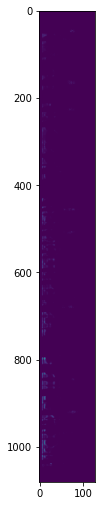

torch.Size([1, 1081, 128])

/content/spec_augment/exp/nb_SparseImageWarp.py:309: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor((queries - floor), dtype=grid_type, device=grid_device)


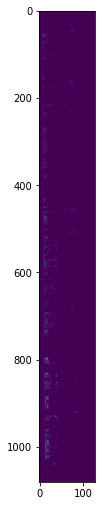

torch.Size([1, 1081, 128])

In [5]:
import random
def time_warp(spec, W=5):
    num_rows = spec.shape[1]
    spec_len = spec.shape[2]
    device = spec.device
    
    y = num_rows//2
    horizontal_line_at_ctr = spec[0][y]
    assert len(horizontal_line_at_ctr) == spec_len
    
    point_to_warp = horizontal_line_at_ctr[random.randrange(W, spec_len - W)]
    assert isinstance(point_to_warp, torch.Tensor)

    # Uniform distribution from (0,W) with chance to be up to W negative
    dist_to_warp = random.randrange(-W, W)
    src_pts, dest_pts = (torch.tensor([[[y, point_to_warp]]], device=device), 
                         torch.tensor([[[y, point_to_warp + dist_to_warp]]], device=device))
    warped_spectro, dense_flows = sparse_image_warp(spec, src_pts, dest_pts)
    return warped_spectro.squeeze(3)

def test_time_warp():
    tensor_to_img(time_warp(spec))
tensor_to_img(spec)    
test_time_warp()

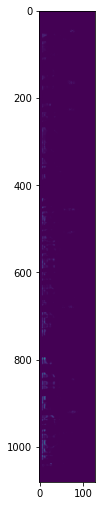

torch.Size([1, 1081, 128])

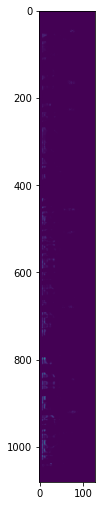

torch.Size([1, 1081, 128])

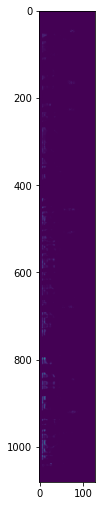

torch.Size([1, 1081, 128])

In [6]:
def freq_mask(spec, F=30, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    num_mel_channels = cloned.shape[1]
    
    for i in range(0, num_masks):        
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f) 
        if (replace_with_zero): cloned[0][f_zero:mask_end] = 0
        else: cloned[0][f_zero:mask_end] = cloned.mean()
    
    return cloned

def test_freq_mask():
    tensor_to_img(freq_mask(spec))
    # Two Masks...
    tensor_to_img(freq_mask(spec, num_masks=2))
    # with zeros
    tensor_to_img(freq_mask(spec, num_masks=2, replace_with_zero=True))
test_freq_mask()



Time masking is applied so that t consecutive time steps [t0, t0 + t) are masked, where t is first chosen from a uniform distribution from 0 to the time mask parameter T, and t0 is chosen from [0, τ − t). We introduce an upper bound on the time mask so that a time mask cannot be wider than p times the number of time steps.

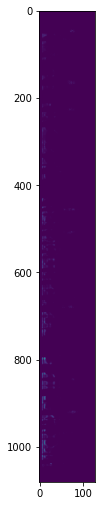

torch.Size([1, 1081, 128])

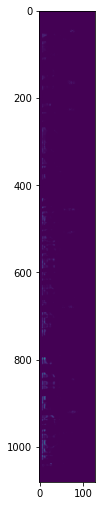

torch.Size([1, 1081, 128])

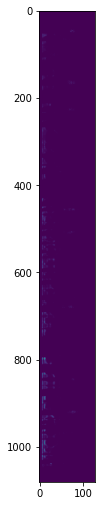

torch.Size([1, 1081, 128])

In [7]:
def time_mask(spec, T=40, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    len_spectro = cloned.shape[2]
    print(len_spectro)
    
    for i in range(0, num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero): cloned[0][:,t_zero:mask_end] = 0
        else: cloned[0][:,t_zero:mask_end] = cloned.mean()
    return cloned
def test_time_mask():
    tensor_to_img(time_mask(spec))
    # Two Masks...
    tensor_to_img(time_mask(spec, num_masks=2))
    # with zeros
    tensor_to_img(time_mask(spec, num_masks=2, replace_with_zero=True))
test_freq_mask()